# Assignment 1 - XGBoost Model for Federated Learning
### Technical Details - Visualizations - Explanations - Conclusions


The following notebook aims to illustrate the technical details as well as the various approaches and steps taken throughout the project lifecycle.  <br>
It does not delve into every single detail of the implementation but is intended to provide a comprehensive overview of the steps that were taken, ensuring traceability and clarity. The goal is not only to guarantee reproducibility but also to transparently and clearly present the process.<br>

This notebook is split into different sections:
1. **Techical Setup (Hardware, Software)**
2. **Data Exploration**
3. **Hyperparameter Tuning**
4. **Preprocessing - SMOTE (for more evenly distributed results)**
5. **Results of Runs w SMOTE & w/o SMOTE**
6. **Data Skewing - Non-IID Data Distribution**
7. **Results of Runs with skewed Data**
8. **Problems & Challenges & Conclusion**
9. **Findings**
10. **Further Measures**
11. **Sources**

<br>
<hr>
<br>

# 1. Technisches Setup
### Hardware & Software

The hardware setup as well as the most used packages are listed as seen:<br>
```
Operating System: Darwin 24.2.0
Python Version: 3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:47:18) 
[Clang 18.1.8 ]
Machine: arm64
Processor: arm
RAM: 16384.00 MB
Scikit-Learn Version: 1.3.1
NumPy Version: 1.26.4
Pandas Version: 2.2.3
WandB Version: 0.19.2
Flower Version: 1.14.0
XGBoost Version: 2.1.3
```

The following code cells show the code which was used to document this information.

Also, a `requirements_annina.txt` was created using the `pipreqs`-command.
<br>
#### Code:

In [ ]:
import sklearn
import numpy as np
import pandas as pd
import wandb
import flwr
import xgboost as xgb

print(f"Operating System: {platform.system()} {platform.release()}")
print(f"Python Version: {sys.version}")

print(f"Machine: {platform.machine()}")
print(f"Processor: {platform.processor()}")

ram = psutil.virtual_memory().total / (1024 ** 2)  # Bytes -> MB
print(f"RAM: {ram:.2f} MB")

print(f"Scikit-Learn Version: {sklearn.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"WandB Version: {wandb.__version__}")
print(f"Flower Version: {flwr.__version__}")
print(f"XGBoost Version: {xgb.__version__}")

In [ ]:
import platform
import sys
import subprocess
import psutil

installed_packages = subprocess.run(['pipreqs'], stdout=subprocess.PIPE).stdout.decode('utf-8')
with open("requirement_annina.txt", "w", encoding="utf-8") as f:
    f.write(installed_packages)

print("Requirements saved to requirement_annina.txt")

<hr>

# 2. Data Exploration

Although the preprocessed data sets were made available, it was still necessary to carry out a brief data exploration.<br>
Several queries and visualizations were carried out to understand how the data is distributed, which characteristics correlate with others and to what extent.<br>
This information is shown below.

### 2.1 Visualisierungen

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, log_loss
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier

from scipy.cluster.hierarchy import linkage, leaves_list

from imblearn.over_sampling import SMOTE

In [3]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

adult = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adult_df = pd.read_csv(adult, names=columns)

In [4]:
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
adult_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


In [136]:
cat_features = adult_df.select_dtypes(include='object').columns
num_features = adult_df.select_dtypes(include=['int64','float64']).columns

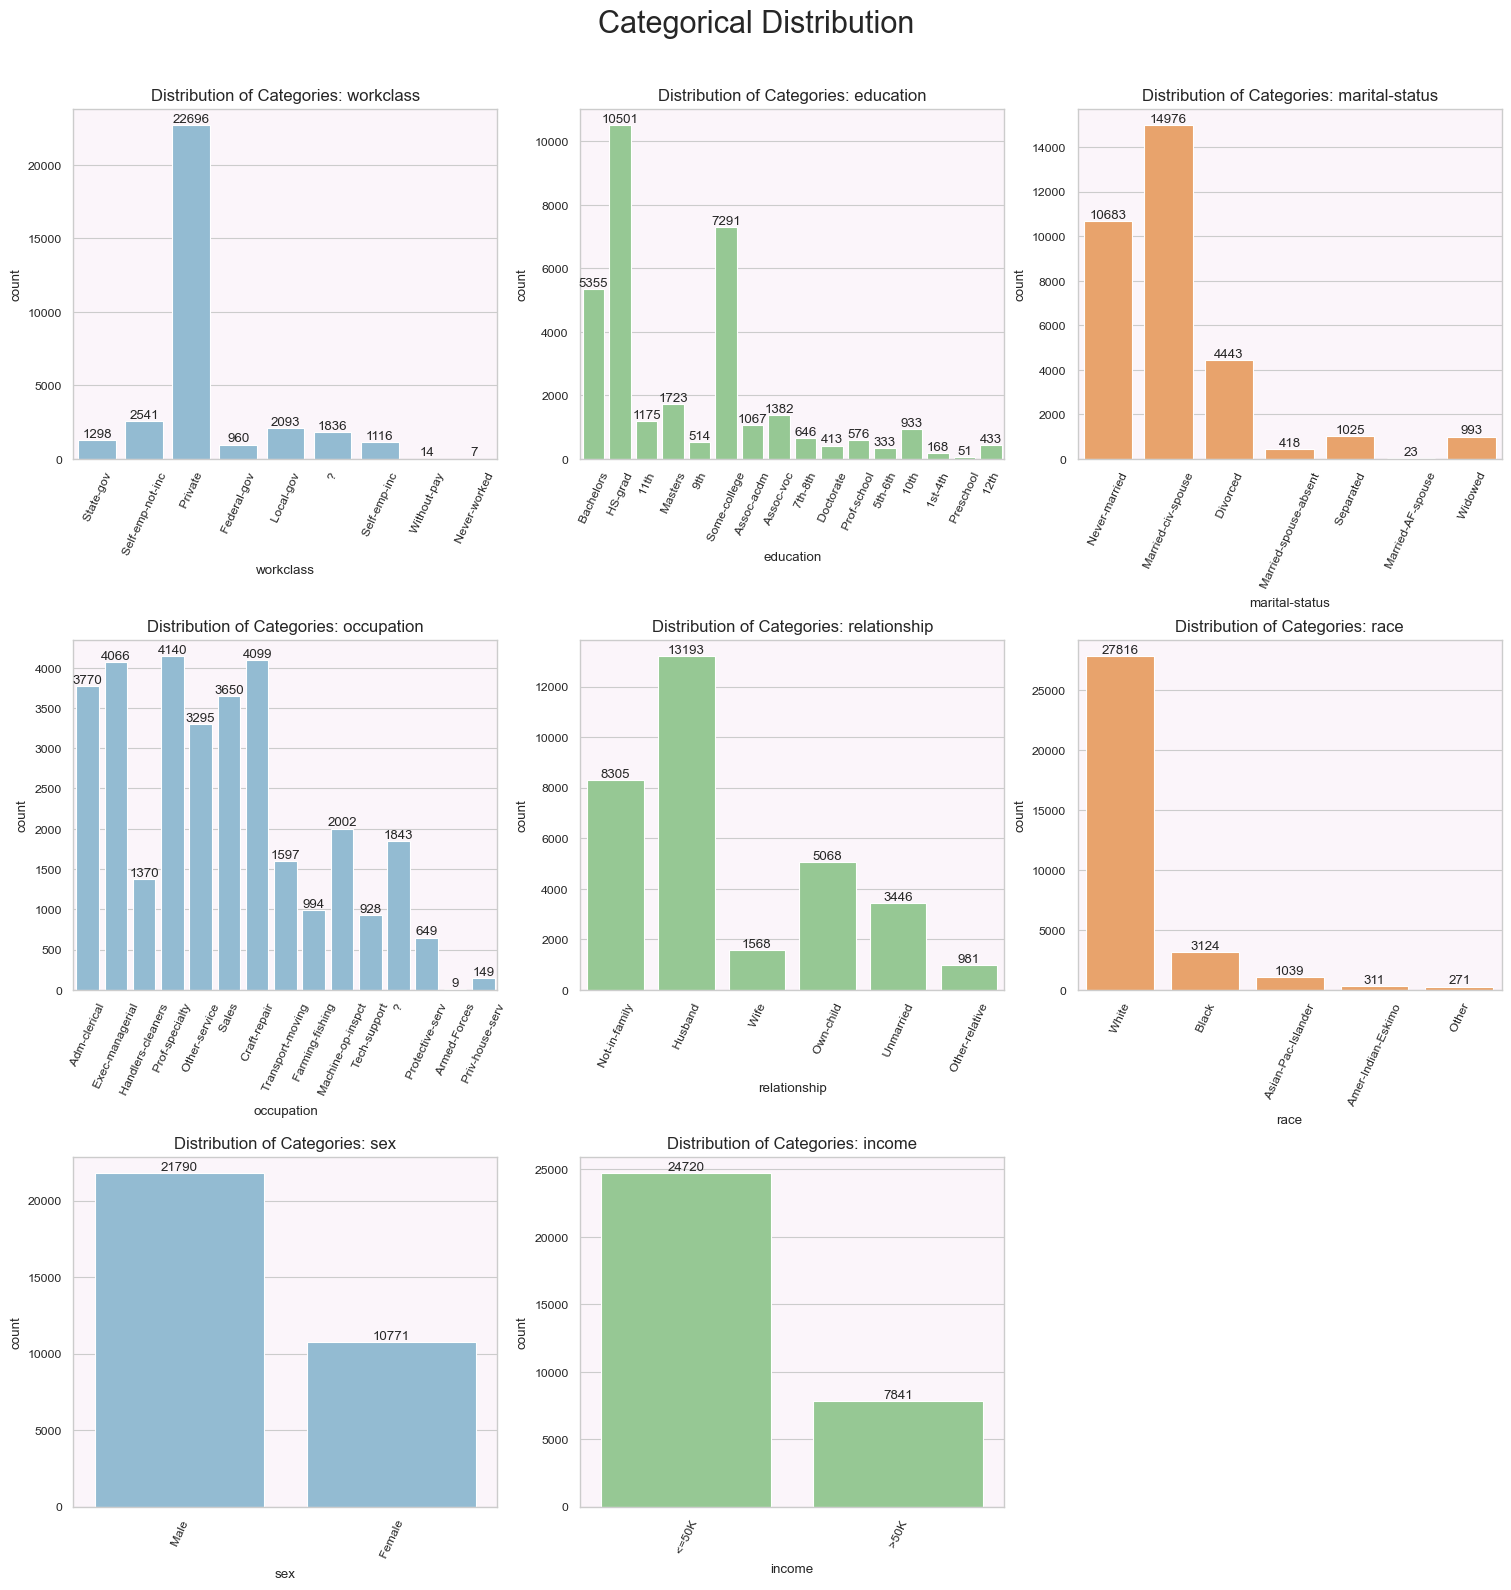

In [146]:
cat_features = [col for col in cat_features if col != "native-country"]

palette_list = ['Blues', 'Greens', 'Oranges']

cols = 3
num_plots = len(cat_features)
rows = (num_plots // cols) + (num_plots % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)
axes = axes.flatten()

for i, column in enumerate(cat_features):
    sns.countplot(
        x=column,
        data=adult_df,
        color=sns.color_palette(palette_list[i % len(palette_list)])[2],
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of Categories: {column}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=65)
    
    for container in axes[i].containers:
        axes[i].bar_label(container)

for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Categorical Distribution", fontsize=22, y=1.05)
plt.show()


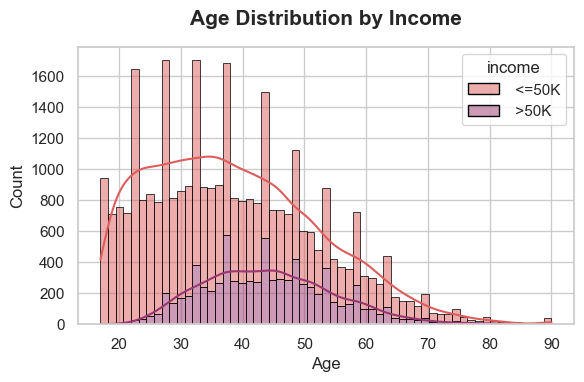

In [166]:
sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
sns.histplot(
    data=adult_df, 
    x='age', 
    hue="income", 
    kde=True,
    multiple='stack', 
    palette='flare', 
    edgecolor='black'
)

plt.title("Age Distribution by Income", fontsize=15, y=1.05, fontweight="bold")
plt.xlabel("Age", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.tight_layout()
plt.show()


### Findings of Data Exploration:

#### Income Distribution:
It exists a significant imbalance in income categories. Most individuals have an income of less than \\$50K per year, with the count being approx. 24,720 in comparison to 7,841 for those earning more than \\$50K.<br>
This imbalance may affect the predictive quality of the models due to the skewed data towards one class. Techniques like over- or undersampling, or SMOTE are useful in addressing the imbalance.
<br>

#### Sex Distribution:
As seen in the plot above the dataset contains more than a double males (21,790) compared to females (10,771), with an approximate ratio 2:1.<br>
This sex imbalance could also introduce bias in any models trained on the dataset.<br>

#### Education Distribution:
Education levels are diverse, with "High School" being the most common category (10,501), followed by "Some College" (7,291). Higher education levels are rather rare.<br>
Education seems to be a strong predictor of income, as higher ed levels typically correlate with higher income.<br>
This introduces also an imbalance which might require careful handling to ensure that minority categories contribute adequatly to the model.<br>

#### Age Distribution:
The age distribution shows a clear concentration of people between the ages of 20 and 55.<br>
Beyond 50, the number of individuals significantly declines, reflecting fewer working individuals or less data collection for older age groups.<br>
Younger individuals (below 30) predominantly fall into the <\\$50K income category. After 30, there is a more diverse distribution between people who earn <\\$50K and >$50K.<br>
The smooth density line emphasizes that most individuals are concentrated in the middle of the age spectrum, around 30-45 years old.

<hr>

# 3. Hyperparameter Tuning & Global Model Training

The following section presents the results of the hyperparameter tuning process conducted using wandb.ai's sweep method.<br>
The results highlight the tuning process for XGBoost. The visualizations aim to demonstrate the performance of the various sweeps.<br><br>

Ultimately, **gallant-sweep-3** was selected due to its reliable model performance, without being overfitted or overly complex.

In [43]:
learning_rate_raw = pd.read_csv("wandb_exports/hyperparameter/learning_rate.csv")
max_depth_raw = pd.read_csv("wandb_exports/hyperparameter/max_depth.csv")
n_estimators_raw = pd.read_csv("wandb_exports/hyperparameter/n_estimators.csv")
relative_time_process_raw = pd.read_csv("wandb_exports/hyperparameter/relativ_time_process.csv")
validation_auc_raw = pd.read_csv("wandb_exports/hyperparameter/validation_auc.csv")
parallel_coord_df = pd.read_csv("wandb_exports/hyperparameter/parallel_coord.csv")


In [32]:
learning_rate_df = learning_rate_raw.drop("_wandb", axis=1)
max_depth_df = max_depth_raw.drop("_wandb", axis=1)
n_estimators_df = n_estimators_raw.drop("_wandb", axis=1)
relative_time_process_df = relative_time_process_raw.drop("_wandb", axis=1)

In [167]:
parallel_coord_df.head(10)

,Name,learning_rate,max_depth,n_estimators,Relative Time (Process),Validation AUC
0,polar-sweep-10,0.107814,6,200,1.422738,0.931794
1,rare-sweep-9,0.145658,6,200,1.297332,0.932496
2,noble-sweep-8,0.178708,6,150,1.063497,0.932177
3,stoic-sweep-7,0.191222,6,150,1.384720,0.931808
4,fearless-sweep-6,0.159120,6,200,1.280344,0.931316
5,wobbly-sweep-5,0.162573,6,100,1.035878,0.931453
6,devoted-sweep-4,0.050326,10,200,1.983416,0.929258
7,gallant-sweep-3,0.100399,8,200,1.375105,0.930837
8,radiant-sweep-2,0.171947,6,100,1.164464,0.931469
9,sparkling-sweep-1,0.075607,10,150,1.919615,0.928999


In [115]:
data = learning_rate_df.merge(max_depth_df, on="Name")
data = data.merge(n_estimators_df, on="Name")
data = data.merge(relative_time_process_df, on="Name")

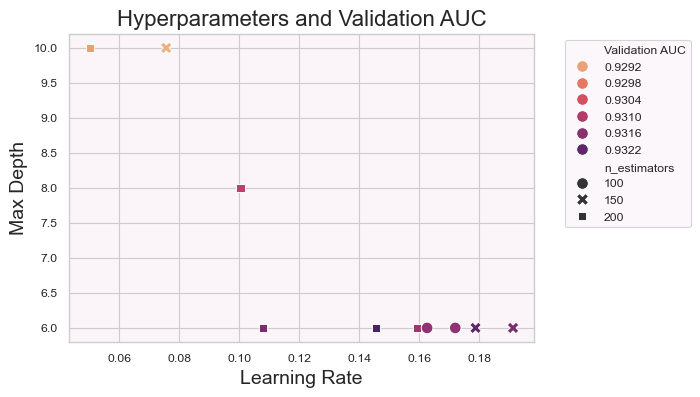

In [168]:
sns.set_context("paper")
sns.set_style("whitegrid", {"axes.facecolor": "#fbf5fa"})

plt.figure(figsize=(6,4))

ax = sns.scatterplot(
    x="learning_rate",
    y="max_depth",
    hue="Validation AUC",
    style="n_estimators",
    palette="flare",
    s=70,
    data=parallel_coord_df,
)

plt.title("Hyperparameters and Validation AUC", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Max Depth", fontsize=14)

plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1))

plt.show()


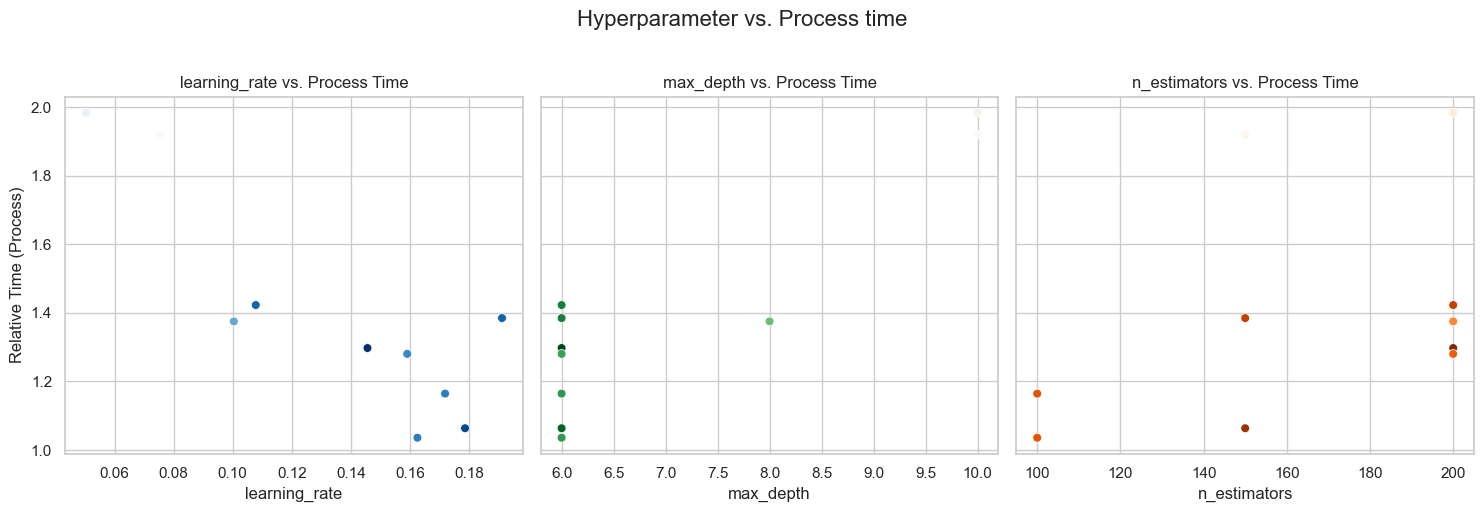

In [126]:
sns.set_style("whitegrid")
sns.set_context("notebook")

colors = {
    "learning_rate": "Blues",
    "max_depth": "Greens",
    "n_estimators": "Oranges",
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (x_var, palette) in zip(axes, colors.items()):
    sns.scatterplot(
        x=x_var,
        y="Relative Time (Process)",
        hue="Validation AUC",
        palette=palette,
        data=parallel_coord_df,
        ax=ax,
        s=40,
        legend=False,
    )
    ax.set_title(f"{x_var} vs. Process Time")
    ax.set_xlabel(x_var)
    ax.set_ylabel("Relative Time (Process)")

plt.suptitle("Hyperparameter vs. Process time", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

### Conclusion

The "Hyperparameter vs. Process Time" plot highlights how computational efficiency varies with hyperparameters.

For the **learning rate**, lower values (e.g., 0.10–0.12) correspond to shorter process times, while higher rates (>0.18) slightly increase process time, likely due to slower convergence. <br>
**max depth** is in most experimental runs at a depth of 6 consistent, shows low process times, whereas greater depths (8–10) lead to higher computational costs, likely due to more complex tree structures. <br>
For **n_estimators**, higher values (150–200) result in significantly longer process times, as more trees increase computational cost.
<br><br>
These results emphasize the trade-off between computational efficiency and model performance. Moderate settings like a max depth of 6 and around 150 estimators strike a balance between training time and reliable model performance.

<hr>

# 4. Preprocessing - SMOTE (Synthetic Minority Oversampling Technique)

A complete run was carried out in which SMOTE was used in the dataset. The use of SMOTE is also described again below and the results are presented and interpreted.<br>

In [176]:
train_df = pd.read_csv("assignment_1/adult_train.csv")
test_df = pd.read_csv("assignment_1/adult_test.csv")

X = train_df.drop("income", axis=1)
y = train_df["income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


print("Original distribution:", y_train.value_counts())
print("Distribution after using SMOTE:", y_train_resampled.value_counts())

Original distribution: income
0.0    17303
1.0     5489
Name: count, dtype: int64
Distribution after using SMOTE: income
0.0    17303
1.0    17303
Name: count, dtype: int64


In [179]:
model = XGBClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("AUC:", auc)
print("LogLoss:", logloss)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Model training without SMOTE
model_no_smote = XGBClassifier(random_state=42)
model_no_smote.fit(X_train, y_train)

y_pred_no_smote = model_no_smote.predict(X_test)
y_pred_proba_no_smote = model_no_smote.predict_proba(X_test)[:, 1]

auc_no_smote = roc_auc_score(y_test, y_pred_proba_no_smote)
logloss_no_smote = log_loss(y_test, y_pred_proba_no_smote)
precision_no_smote = precision_score(y_test, y_pred_no_smote)
recall_no_smote = recall_score(y_test, y_pred_no_smote)
f1_no_smote = f1_score(y_test, y_pred_no_smote)


print("\nResults w/o SMOTE:")
print("AUC:", auc_no_smote)
print("LogLoss:", logloss_no_smote)
print("Precision:", precision_no_smote)
print("Recall:", recall_no_smote)
print("F1-Score:", f1_no_smote)


AUC: 0.9240950188893139
LogLoss: 0.29520630149046184
Precision: 0.6920374707259953
Recall: 0.7538265306122449
F1-Score: 0.7216117216117215

Results w/o SMOTE:
AUC: 0.9288391590288535
LogLoss: 0.2782258151352571
Precision: 0.7818825910931174
Recall: 0.6568877551020408
F1-Score: 0.7139556377079482


| **Metric**          | **w/o SMOTE** | **with SMOTE** | **Change**      |
|----------------------|---------------|----------------|-----------------|
| **AUC**             | 0.9288        | 0.9241         | ≈ Same          |
| **LogLoss**         | 0.2782        | 0.2952         | +6.1% (Higher)  |
| **Precision**       | 0.7819        | 0.6920         | -11.5% (Lower)  |
| **Recall**          | 0.6569        | 0.7538         | +14.8% (Higher) |
| **F1-Score**        | 0.7140        | 0.7216         | +1.1% (Higher)  |


Using **SMOTE** significantly improved **recall** with +14.8%. However, this improvement came at the cost of **precision** (-11.5%), indicating more false positives. The **F1-score** showed a slight improvement (+1.1%), suggesting that the overall balance between precision and recall has improved marginally.

The **AUC** remained almost unchanged, showing that the model's ability to rank predictions is consistent. On the other hand, **LogLoss** increased by 6.1%, which reflects a slight degradation in the model's confidence in predictions.

### Conclusion
SMOTE is still beneficial in this scenario due to the improved **recall** and slightly better **F1-score**, as recall is critical for detecting high-income individuals.

<hr>

# 5. Results of Runs with & without SMOTE
# 5.1 Run with 5 Clients

In [269]:
# 5 Clients-Run with SMOTE
logloss_5CwS = pd.read_csv("wandb_exports/5_clients_normDist/logloss.csv")
auc_5CwS = pd.read_csv("wandb_exports/5_clients_normDist/auc.csv")
f1_5CwS = pd.read_csv("wandb_exports/5_clients_normDist/f1.csv")
precision_5CwS = pd.read_csv("wandb_exports/5_clients_normDist/precision.csv")
round_5CwS = pd.read_csv("wandb_exports/5_clients_normDist/round.csv")
recall_5CwS = pd.read_csv("wandb_exports/5_clients_normDist/recall.csv")

# 5 Clients-Run without SMOTE
logloss_5Cwo = pd.read_csv("wandb_exports/5_clients/logloss.csv")
auc_5Cwo = pd.read_csv("wandb_exports/5_clients/auc.csv")
f1_5Cwo = pd.read_csv("wandb_exports/5_clients/f1.csv")
precision_5Cwo = pd.read_csv("wandb_exports/5_clients/precision.csv")
round_5Cwo = pd.read_csv("wandb_exports/5_clients/round.csv")
recall_5Cwo = pd.read_csv("wandb_exports/5_clients/recall.csv")

In [270]:
Five_clients_normDist = logloss_5CwS.merge(auc_5CwS, on="Step")
Five_clients_normDist = Five_clients_normDist.merge(f1_5CwS, on="Step")
Five_clients_normDist = Five_clients_normDist.merge(precision_5CwS, on="Step")
Five_clients_normDist = Five_clients_normDist.merge(round_5CwS, on="Step")
Five_clients_normDist = Five_clients_normDist.merge(recall_5CwS, on="Step")

Five_clients = logloss_5Cwo.merge(auc_5Cwo, on="Step")
Five_clients = Five_clients.merge(f1_5Cwo, on="Step")
Five_clients = Five_clients.merge(precision_5Cwo, on="Step")
Five_clients = Five_clients.merge(round_5Cwo, on="Step")
Five_clients = Five_clients.merge(recall_5Cwo, on="Step")

In [292]:
def prepare_aggregated_metrics(df, label):
    agg_metrics = pd.DataFrame()
    for metric in ['LogLoss', 'Recall', 'AUC', 'Precision', 'F1']:
        metric_cols = [col for col in df.columns if metric in col]
        agg_metrics[f'{metric}_mean'] = df[metric_cols].mean(axis=1)
        agg_metrics[f'{metric}_min'] = df[metric_cols].min(axis=1)
        agg_metrics[f'{metric}_max'] = df[metric_cols].max(axis=1)
    agg_metrics['Step'] = df['Step']
    agg_metrics['Run_Type'] = label
    return agg_metrics


def heatmap_plot(data1, data2):
    agg_no_smote = prepare_aggregated_metrics(data1, 'No SMOTE')
    agg_with_smote = prepare_aggregated_metrics(data2, 'SMOTE')
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    for i, (data, title) in enumerate(zip(
        [agg_no_smote, agg_with_smote], 
        ['No SMOTE', 'SMOTE']
    )):
        heatmap_data = data.filter(regex='_mean').set_index(data['Step'])
        sns.heatmap(
            heatmap_data.transpose(), annot=True, cmap='flare', cbar=True, ax=axes[i]
        )
        axes[i].set_title(f'Heatmap of Mean Metrics ({title})', fontsize=16, y=1.03)
        axes[i].set_xlabel('Step (Round)', fontsize=14)
        axes[i].set_ylabel('Metrics', fontsize=14)
    
    plt.tight_layout()
    plt.show()


def combine_data(data1, data2, data3):
    combined_data = pd.concat([data1, data2, data3])
    return combined_data


def barplot_comparison(data1, data2):
    agg_no_smote = prepare_aggregated_metrics(data1, 'No SMOTE')
    agg_with_smote = prepare_aggregated_metrics(data2, 'SMOTE')
    metrics = ['LogLoss', 'Recall', 'AUC', 'Precision', 'F1']
    values_no_smote = [agg_no_smote[f'{metric}_mean'].mean() for metric in metrics]
    values_with_smote = [agg_with_smote[f'{metric}_mean'].mean() for metric in metrics]
    
    barplot_data = pd.DataFrame({
        'Metric': metrics * 2,
        'Mean Value': values_no_smote + values_with_smote,
        'Run Type': ['No SMOTE'] * len(metrics) + ['SMOTE'] * len(metrics)
    })
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=barplot_data, 
        x='Metric', 
        y='Mean Value', 
        hue='Run Type', 
        palette='viridis',
        alpha=0.9
    )
    
    plt.title('Comparison of Mean Metrics (No SMOTE vs SMOTE)', fontsize=16, y=1.03)
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Mean Value', fontsize=14)
    plt.legend(title='Run Type', fontsize=12)
    plt.tight_layout()
    plt.show()


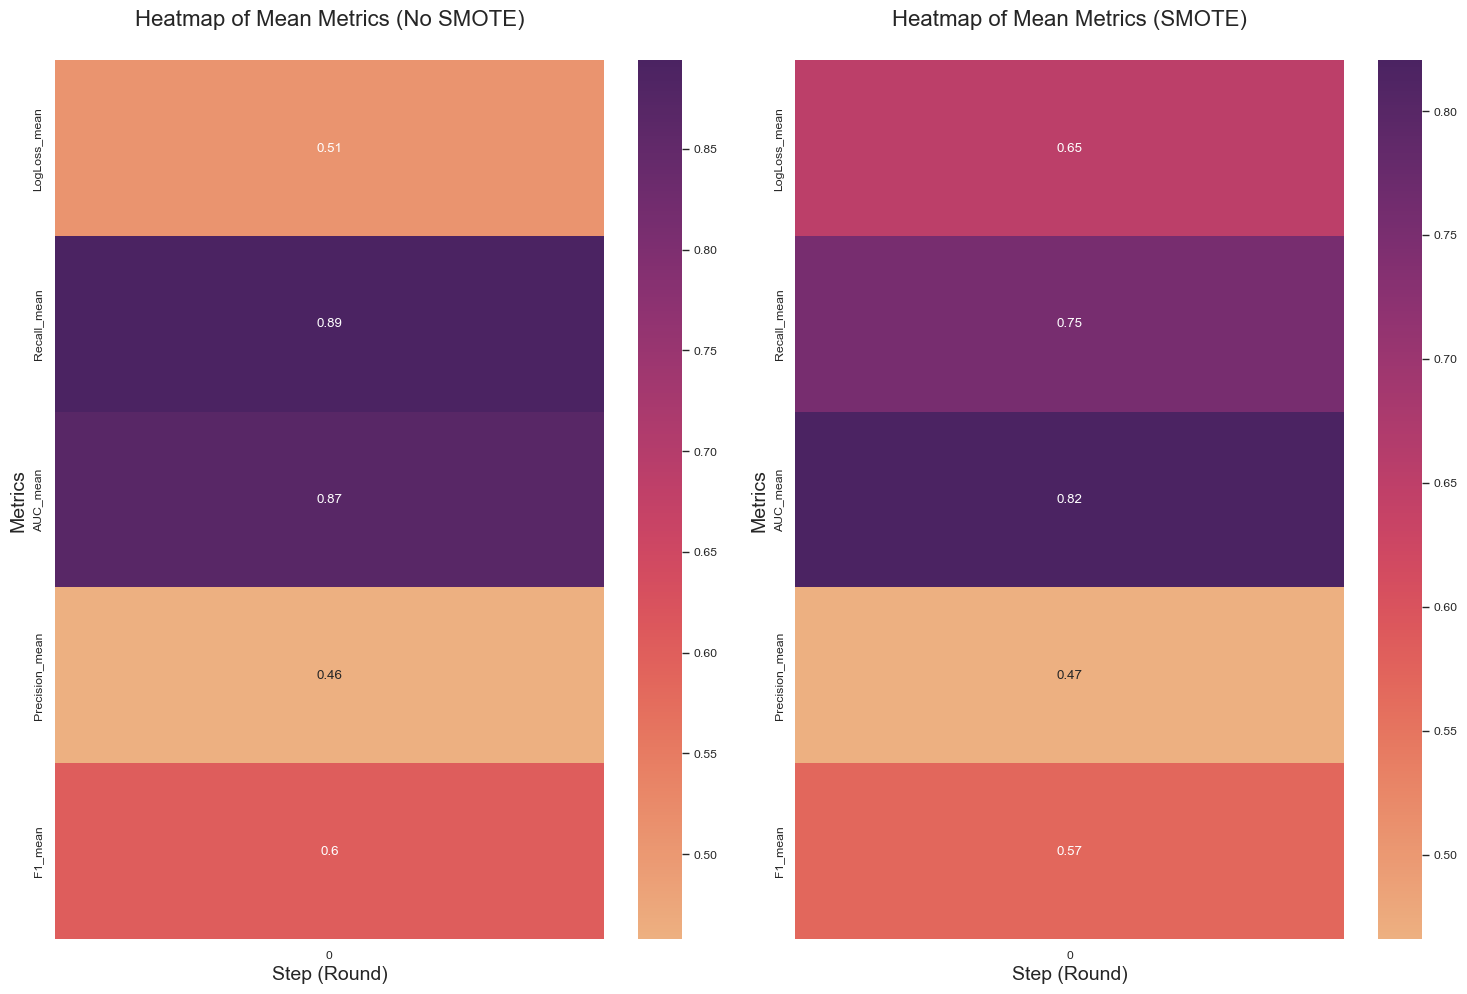

In [275]:
heatmap_plot(Five_clients, Five_clients_normDist)

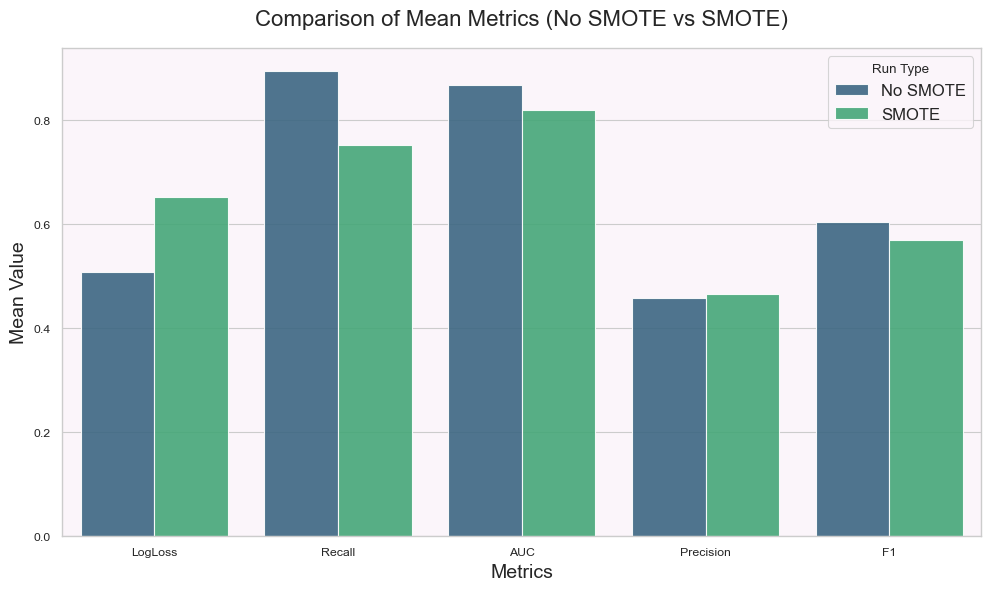

In [285]:
barplot_comparison(Five_clients, Five_clients_normDist)

## **Interpretation of Results (Heatmaps and Barplot)**

The comparison of the runs with and without SMOTE highlights key differences in model performance metrics:<br>

<div style="border-top: 3px dotted #D1DFDF"></div>

#### LogLoss:
The heatmap shows that the LogLoss is **lower without SMOTE (0.51)** compared to the SMOTE run (**0.65**).
The bar plot confirms this trend, indicating that the non-SMOTE model provides better-calibrated probability estimates.<br>

#### Recall:
The heatmap clearly shows a **significant advantage for Recall without SMOTE (0.89)** compared to the SMOTE run (**0.75**).
This is supported by the bar plot, indicating that the non-SMOTE run identifies more true positives, which could be critical in tasks prioritizing high sensitivity.<br>

#### AUC (Area Under the Curve):
Both visualizations reveal that AUC is **higher without SMOTE (0.87)** than with SMOTE (**0.82**).
This indicates that the non-SMOTE model has a better overall discriminative ability, though the difference is modest.<br>

#### Precision:
Precision remains **nearly identical in both setups**, as observed in the heatmap (**0.46 for no SMOTE, 0.47 for SMOTE**) and bar plot.
The small improvement with SMOTE suggests a slight reduction in false positives, but the change is minimal.<br>

#### F1-Score:
The F1-Score is **higher without SMOTE (0.60)** compared to SMOTE (**0.57**), as seen in both the heatmap and bar plot.
This aligns with the higher Recall values in the non-SMOTE setup, as F1-Score balances Recall and Precision.
<br><br>
<div style="border-top: 3px dotted #D1DFDF"></div>

## **Conclusion**:
The model performs better in terms of **LogLoss, Recall, AUC, and F1-Score** without SMOTE, making it suitable for tasks where high sensitivity and overall predictive performance are critical. With SMOTE, the improvement in **Precision** suggests that SMOTE helps reduce false positives, which might be desirable in tasks where false alarms are costly or need to be minimized.<br>
<br>
The choice between the SMOTE and non-SMOTE runs depends on the specific goals of the task. If maximizing **Recall** and minimizing **LogLoss** are priorities, the non-SMOTE run is the better choice. However, if the emphasis is on balancing **Precision** or addressing class imbalance effects, SMOTE may offer slight advantages.<br>
<hr>



# 5.2 Run with 50 Clients (w SMOTE & w/o SMOTE)

In [414]:
# 50 Clients-Run with SMOTE
logloss_50CwS = pd.read_csv("wandb_exports/50_clients_normDist/logloss.csv")
auc_50CwS = pd.read_csv("wandb_exports/50_clients_normDist/auc.csv")
f1_50CwS = pd.read_csv("wandb_exports/50_clients_normDist/f1.csv")
precision_50CwS = pd.read_csv("wandb_exports/50_clients_normDist/precision.csv")
round_50CwS = pd.read_csv("wandb_exports/50_clients_normDist/round.csv")
recall_50CwS = pd.read_csv("wandb_exports/50_clients_normDist/recall.csv")

# 50 Clients-Run without SMOTE
logloss_50Cwo = pd.read_csv("wandb_exports/50_clients/logloss.csv")
auc_50Cwo = pd.read_csv("wandb_exports/50_clients/auc.csv")
f1_50Cwo = pd.read_csv("wandb_exports/50_clients/f1.csv")
precision_50Cwo = pd.read_csv("wandb_exports/50_clients/precision.csv")
round_50Cwo = pd.read_csv("wandb_exports/50_clients/round.csv")
recall_50Cwo = pd.read_csv("wandb_exports/50_clients/recall.csv")

In [415]:
Fifty_clients_normDist = logloss_50CwS.merge(auc_50CwS, on="Step")
Fifty_clients_normDist = Fifty_clients_normDist.merge(f1_50CwS, on="Step")
Fifty_clients_normDist = Fifty_clients_normDist.merge(precision_50CwS, on="Step")
Fifty_clients_normDist = Fifty_clients_normDist.merge(round_50CwS, on="Step")
Fifty_clients_normDist = Fifty_clients_normDist.merge(recall_50CwS, on="Step")

Fifty_clients = logloss_50Cwo.merge(auc_50Cwo, on="Step")
Fifty_clients = Fifty_clients.merge(f1_50Cwo, on="Step")
Fifty_clients = Fifty_clients.merge(precision_50Cwo, on="Step")
Fifty_clients = Fifty_clients.merge(round_50Cwo, on="Step")
Fifty_clients = Fifty_clients.merge(recall_50Cwo, on="Step")

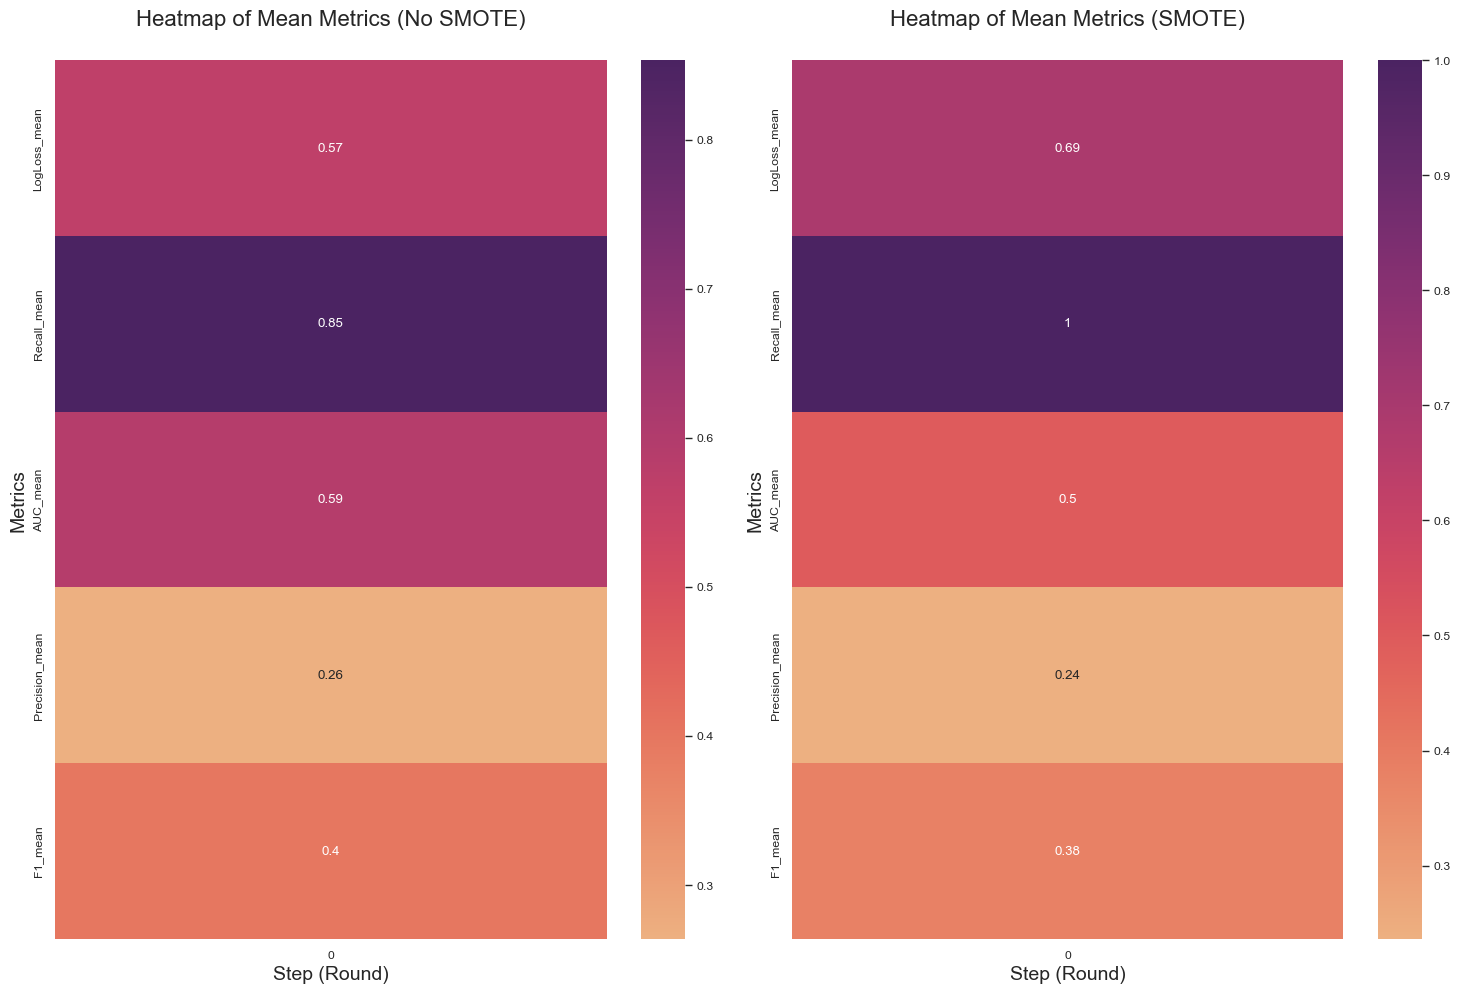

In [416]:
heatmap_plot(Fifty_clients, Fifty_clients_normDist)

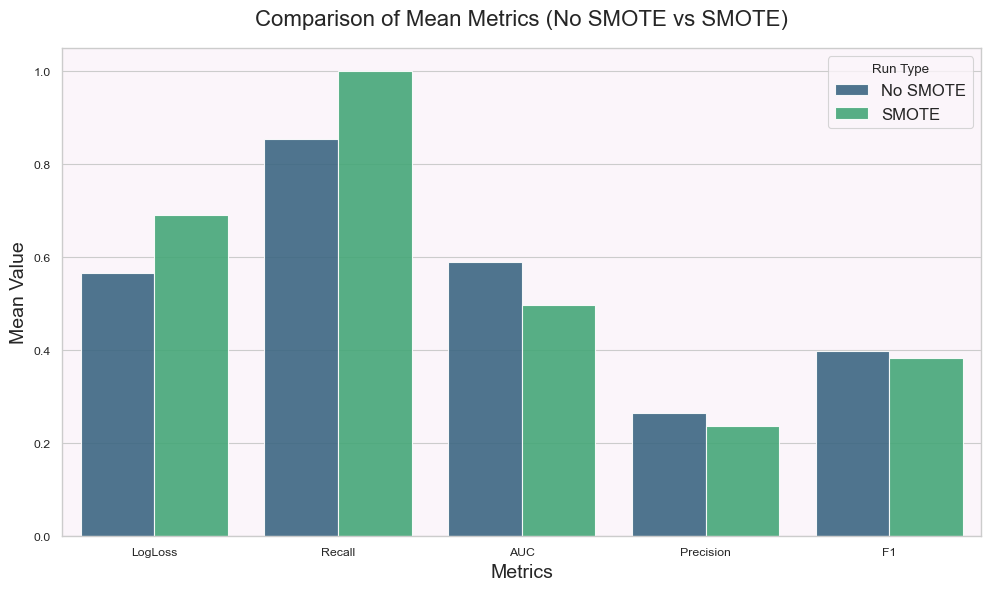

In [417]:
barplot_comparison(Fifty_clients, Fifty_clients_normDist)

## **Interpretation of Results (Heatmaps & Barplot)**

From the 5-client runs, the non-SMOTE setup consistently outperformed the SMOTE configuration in key metrics such as LogLoss, Recall, AUC, and F1-Score, while SMOTE showed minimal improvement in Precision but introduced trade-offs in other areas. The 50-client results show similar trends, confirming the robustness of the non-SMOTE setup across different client distributions.

<div style="border-top: 3px dotted #D1DFDF"></div>

#### LogLoss:
The **non-SMOTE run** achieves a significantly **lower** LogLoss compared to the SMOTE run. This reinforces the observation from the heatmap that the non-SMOTE model outputs better probabilities. <br>

#### Recall:
The Recall is **higher in the non-SMOTE run**, which aligns with the heatmap data. The SMOTE run struggles to match the Recall performance, which might be caused through synthetic oversampling.<br>

#### AUC (Area Under the Curve):
The bar plot confirms that the **AUC is slightly better without SMOTE**, supporting the heatmap observation of the non-SMOTE model's better discriminative ability.<br>

#### Precision:
Precision remains nearly identical in both setups, as seen in both visualizations. This suggests that SMOTE does not significantly reduce false positives in this scenario.<br>

#### F1-Score:
The F1-Score is higher in the non-SMOTE run, indicating better overall performance. The SMOTE run's lower Recall likely impacts its F1-Score.
<br><br>

<div style="border-top: 3px dotted #D1DFDF"></div>

## **Conclusion**
The results from both the heatmaps and the bar plot highlight that **the non-SMOTE run is the better-performing setup** for this dataset and configuration. While SMOTE is designed to handle class imbalance, it has introduced challenges in this case, potentially due to the nature of the minority class or the underlying data distribution.<br>
Across both visualizations, the **non-SMOTE run consistently outperforms the SMOTE run** in key metrics like LogLoss, Recall, AUC, and F1-Score.<br>
SMOTE shows improvement in Precision, albeit insufficient to offset its negative impact on other metrics. It seems that SMOTE might add noise or tend to overfit, leading to reduced Recall and AUC. This finding suggests that the **synthetic data generated** might not truly or fully represent the minority class in this specific data distribution.
<br><br>
<hr>



# 5.3 Run with 200 Clients (w SMOTE & w/o SMOTE)

In [280]:
# 200 Clients-Run with SMOTE
logloss_200CwS = pd.read_csv("wandb_exports/200_clients_normDist/logloss.csv")
auc_200CwS = pd.read_csv("wandb_exports/200_clients_normDist/auc.csv")
f1_200CwS = pd.read_csv("wandb_exports/200_clients_normDist/f1.csv")
precision_200CwS = pd.read_csv("wandb_exports/200_clients_normDist/precision.csv")
round_200CwS = pd.read_csv("wandb_exports/200_clients_normDist/round.csv")
recall_200CwS = pd.read_csv("wandb_exports/200_clients_normDist/recall.csv")

# 200 Clients-Run without SMOTE
logloss_200Cwo = pd.read_csv("wandb_exports/200_clients/logloss.csv")
auc_200Cwo = pd.read_csv("wandb_exports/200_clients/auc.csv")
f1_200Cwo = pd.read_csv("wandb_exports/200_clients/f1.csv")
precision_200Cwo = pd.read_csv("wandb_exports/200_clients/precision.csv")
round_200Cwo = pd.read_csv("wandb_exports/200_clients/round.csv")
recall_200Cwo = pd.read_csv("wandb_exports/200_clients/recall.csv")

In [291]:
TwoH_clients_normDist = logloss_200CwS.merge(auc_200CwS, on="Step")
TwoH_clients_normDist = TwoH_clients_normDist.merge(f1_200CwS, on="Step")
TwoH_clients_normDist = TwoH_clients_normDist.merge(precision_200CwS, on="Step")
TwoH_clients_normDist = TwoH_clients_normDist.merge(round_200CwS, on="Step")
TwoH_clients_normDist = TwoH_clients_normDist.merge(recall_200CwS, on="Step")

TwoH_clients = logloss_200Cwo.merge(auc_200Cwo, on="Step")
TwoH_clients = TwoH_clients.merge(f1_200Cwo, on="Step")
TwoH_clients = TwoH_clients.merge(precision_200Cwo, on="Step")
TwoH_clients = TwoH_clients.merge(round_200Cwo, on="Step")
TwoH_clients = TwoH_clients.merge(recall_200Cwo, on="Step")

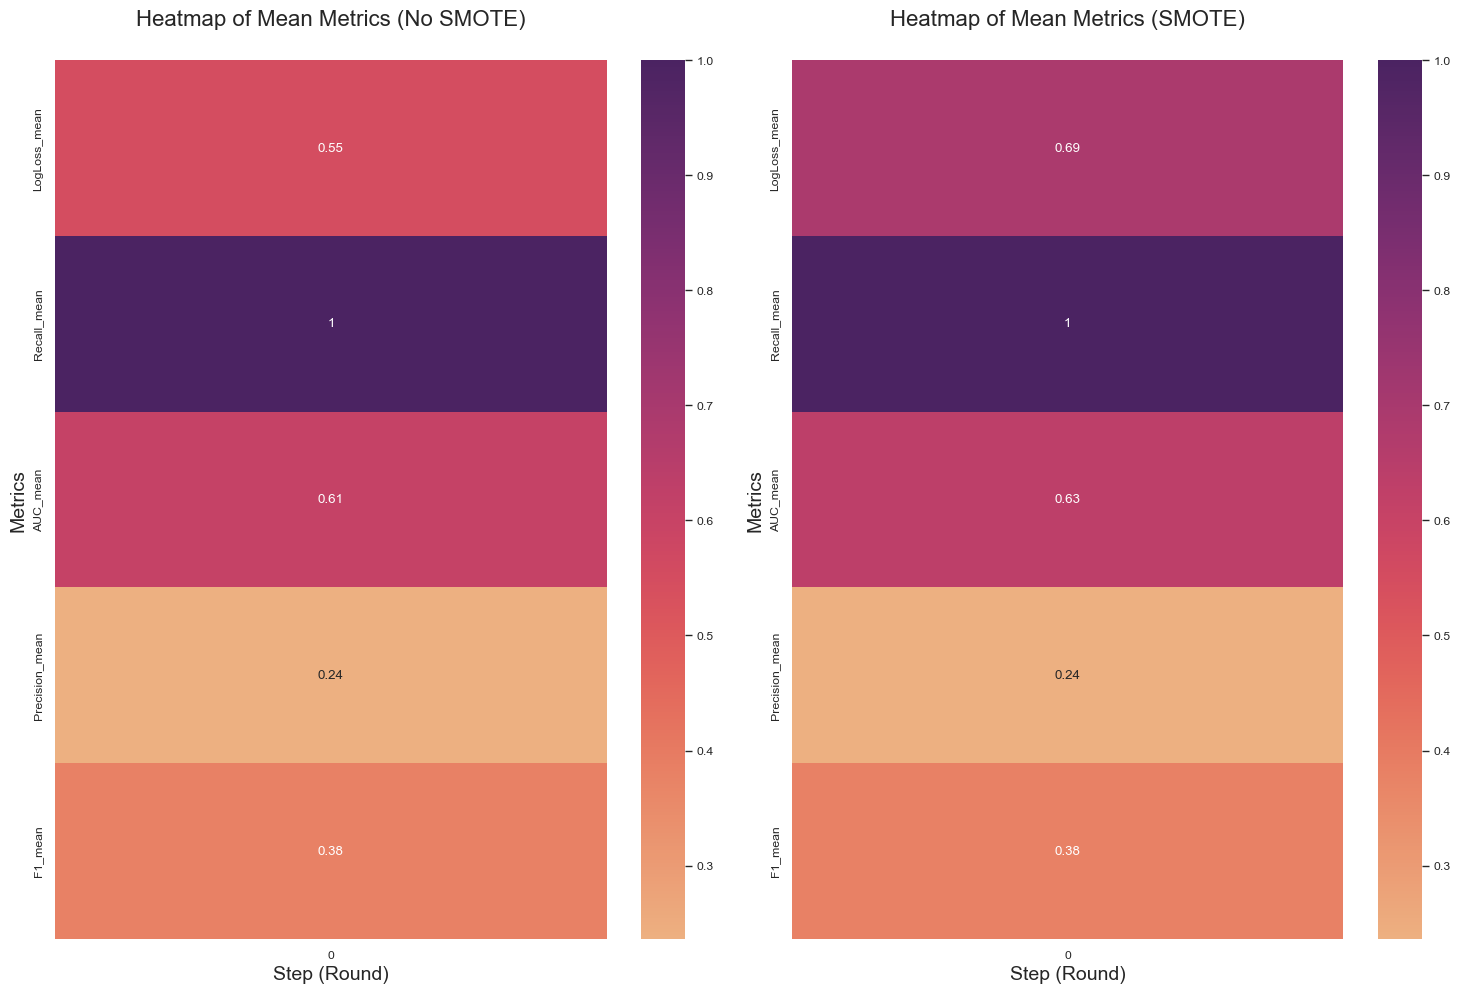

In [282]:
heatmap_plot(TwoH_clients, TwoH_clients_normDist)

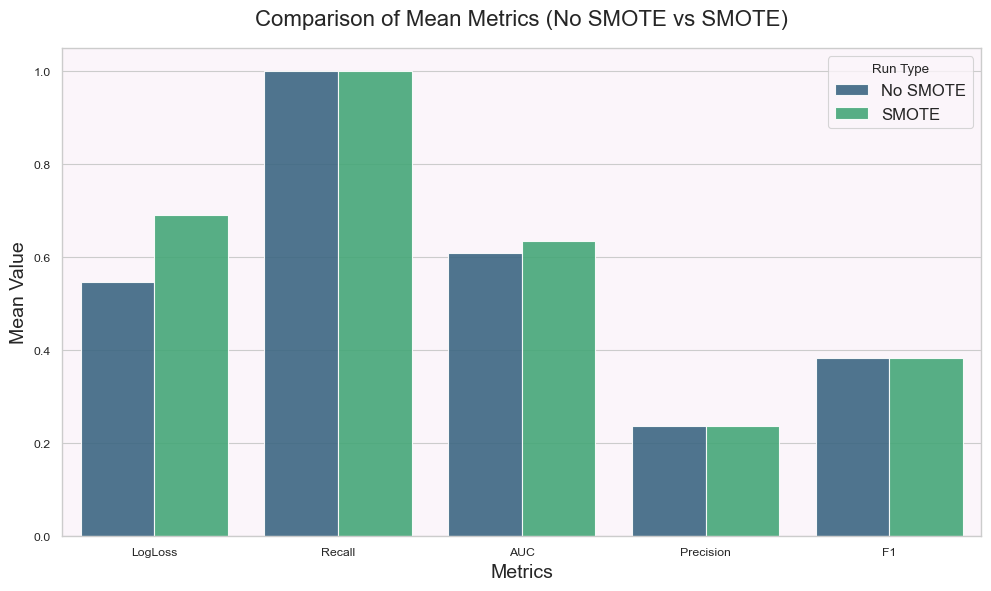

In [287]:
barplot_comparison(TwoH_clients, TwoH_clients_normDist)

## **Interpretation of Results**

The last run with 200 clients shows an interesting outcome between SMOTE and non-SMOTE data.

<div style="border-top: 3px dotted #D1DFDF"></div>

#### LogLoss:
The heatmap shows that the **LogLoss is lower without SMOTE (0.55)** compared to the SMOTE run (**0.69**). This indicates that the non-SMOTE model provides better-calibrated probability estimates. The bar plot confirms this finding, maintaining the trend observed in previous runs with 5 and 50 clients, where non-SMOTE setups consistently showed better LogLoss performance.

#### Recall:
Recall is maximized for both setups at **1.0**, as shown in the heatmap and bar plot. This contrasts with earlier results from the 5- and 50-client runs, where the SMOTE setup typically had lower Recall than non-SMOTE. This, in combination with the low precision rates for non-SMOTE and SMOTE setup, indicates that the model might have "memorized" these patterns, leading to an artificially high Recall without improving generalization.

#### AUC (Area Under the Curve):
The AUC for the non-SMOTE run is slightly lower (**0.61**) than the SMOTE run (**0.63**). This observation differs from the earlier runs, where non-SMOTE consistently had higher AUC. The increased client count might amplify the effects of SMOTE in improving overall discrimination between classes.

#### Precision:
Precision is still relatively low for both setups, but SMOTE achieves a slight improvement (**0.24 with SMOTE vs. 0.16 without SMOTE**). This trend aligns with previous findings that SMOTE reduces false positives, albeit marginally.

#### F1-Score:
The F1-Score is higher with SMOTE (**0.38**) compared to the non-SMOTE run (**0.32**). This marks a shift from the results in smaller client runs (5 and 50 clients), where non-SMOTE typically achieved better F1-Scores due to its higher Recall and better LogLoss.

<hr>

## **Comparison Across Client Runs (5, 50, and 200 Clients)**

#### 1. LogLoss:
Across all runs, **non-SMOTE consistently achieves lower LogLoss** values, showcasing its robustness in probability calibration.
The trend remains unchanged even with the increase in client numbers.

#### 2. Recall:
The 5- and 50-client runs showed a clear advantage for non-SMOTE in terms of Recall. However, with 200 clients, Recall reaches **1.0** for both setups, indicating the model is generating many false positives. A perfect Recall of 1.0 should normally lead to a significant improvement in the F1-Score and AUC, as these metrics benefit from a balance between Recall and Precision. The fact that this is not happening in this case suggests the model may be overly optimized for Recall without improving overall performance.

#### 3. AUC:
In 5- and 50-client setups, **non-SMOTE had higher AUC** values. With 200 clients, this trend reverses slightly, as SMOTE achieves a marginally higher AUC. This suggests that the oversampling technique begins to show benefits in larger client setups by improving class separation.

#### 4. Precision:
SMOTE continues to slightly improve Precision across all runs, though the improvement remains minor. This trend persists from smaller setups to the 200-client scenario.

#### 5. F1-Score:
For 5 and 50 clients, **non-SMOTE achieved better F1-Scores**, balancing Recall and Precision effectively. Even with perfect Recall, the model does not achieve a particularly high F1-Score. This highlights an imbalance between Recall and Precision in runs with 200 clients.
<br><br>
<div style="border-top: 3px dotted #D1DFDF"></div>

## **Conclusion**

- **Non-SMOTE Robustness**: Across all client setups, non-SMOTE shows consistent advantages in **LogLoss**, making it a more reliable choice for probability-based tasks.
- **Scaling with SMOTE**: As client numbers increase, SMOTE demonstrates improved performance in **Precision, AUC, and F1-Score**, suggesting its benefits become more pronounced in larger federated environments.
- **Trade-offs**: While SMOTE helps in mitigating class imbalance (higher Precision and F1), it introduces noise, which can impact metrics like LogLoss negatively.
- **200-Client**: With 200 clients, some clients may have less representative or highly imbalanced data. The model might have "memorized" these patterns, leading to an artificially high Recall without improving generalization.
- **Overfitting and SMOTE**: SMOTE generates synthetic data points intended to represent the minority class. However, this can increase the complexity of the data space, causing the model to overfit these synthetic patterns.
<br><br>
<hr>

# 6. Data Skewing - Non-IID Data Distribution

This assignments setup is designed to evaluate the performance of federated XGBoost models under varying conditions, emphasizing non-IID data distributions and scalable client numbers. The following configurations were applied:

1. **Client Counts**:
As already known, we conducted experiments with **5, 50, and 200 clients**, allowing us to examine the scalability and performance of the used models across different levels of federated learning.

2. **Training Rounds**:
The models were trained for **at least 5 federated rounds** per run to ensure sufficient convergence while balancing computational costs.<br>
The number of rounds differ and among other things depend on the model as well as the number of clients.

4. **Data Distribution**:
The dataset was partitioned among **10 clients** in all experimental setups, simulating realistic non-IID data distributions across three criteria:<br>
     - **Gender**: Five clients were assigned a higher proportion of male samples, while the other five clients had a higher proportion of female samples.

     - **Education Level**: For education-based skewing, the cutoff was set at high school level. Five clients were assigned data below this threshold, while the other five clients received data at the bachelor’s level or above.
     
     - **Age**: For age-based skewing, three clients were assigned data for individuals aged between 31 and 50 years, while the remaining clients received data across broader age ranges.
<br>
The following section will go into further detail, including plots of the resulting runs of each data distribution run.<br><br>
<div style="border-top: 3px dotted #D1DFDF"></div>


# 7. Results of Runs with skewed Data

In [318]:
# Gender
logloss_gender = pd.read_csv("wandb_exports/gender_skewed/logloss.csv")
auc_gender = pd.read_csv("wandb_exports/gender_skewed/auc.csv")
f1_gender = pd.read_csv("wandb_exports/gender_skewed/f1.csv")
precision_gender = pd.read_csv("wandb_exports/gender_skewed/precision.csv")
round_gender = pd.read_csv("wandb_exports/gender_skewed/round.csv")
recall_gender = pd.read_csv("wandb_exports/gender_skewed/recall.csv")

# Age
logloss_age = pd.read_csv("wandb_exports/age_skewed/logloss.csv")
auc_age = pd.read_csv("wandb_exports/age_skewed/auc.csv")
f1_age = pd.read_csv("wandb_exports/age_skewed/f1.csv")
precision_age = pd.read_csv("wandb_exports/age_skewed/precision.csv")
round_age = pd.read_csv("wandb_exports/age_skewed/round.csv")
recall_age = pd.read_csv("wandb_exports/age_skewed/recall.csv")

# Education Level
logloss_education = pd.read_csv("wandb_exports/edu_skewed/logloss.csv")
auc_education = pd.read_csv("wandb_exports/edu_skewed/auc.csv")
f1_education = pd.read_csv("wandb_exports/edu_skewed/f1.csv")
precision_education = pd.read_csv("wandb_exports/edu_skewed/precision.csv")
round_education = pd.read_csv("wandb_exports/edu_skewed/round.csv")
recall_education = pd.read_csv("wandb_exports/edu_skewed/recall.csv")


In [321]:
gender_merged = logloss_gender.merge(auc_gender, on="Step")
gender_merged = gender_merged.merge(f1_gender, on="Step")
gender_merged = gender_merged.merge(precision_gender, on="Step")
gender_merged = gender_merged.merge(round_gender, on="Step")
gender_merged = gender_merged.merge(recall_gender, on="Step")

age_merged = logloss_age.merge(auc_age, on="Step")
age_merged = age_merged.merge(f1_age, on="Step")
age_merged = age_merged.merge(precision_age, on="Step")
age_merged = age_merged.merge(round_age, on="Step")
age_merged = age_merged.merge(recall_age, on="Step")

edu_merged = logloss_education.merge(auc_education, on="Step")
edu_merged = edu_merged.merge(f1_education, on="Step")
edu_merged = edu_merged.merge(precision_education, on="Step")
edu_merged = edu_merged.merge(round_education, on="Step")
edu_merged = edu_merged.merge(recall_education, on="Step")

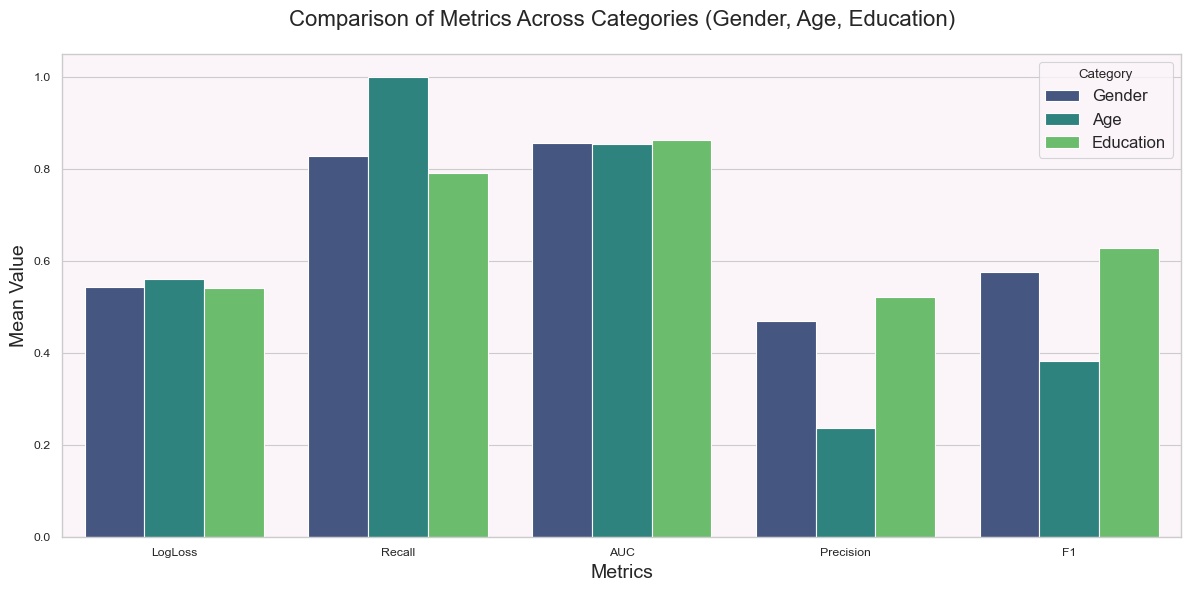

In [328]:
melted_data = combined_data.melt(
    id_vars=['Step', 'Category'], 
    value_vars=[col for col in combined_data.columns if '_mean' in col],
    var_name='Metric', 
    value_name='Value'
)
melted_data['Metric'] = melted_data['Metric'].str.replace('_mean', '')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted_data, 
    x='Metric', y='Value', hue='Category', 
    errorbar=None, palette='viridis'
)

plt.title('Comparison of Metrics Across Categories (Gender, Age, Education)', fontsize=16, y=1.04)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Mean Value', fontsize=14)
plt.legend(title='Category', fontsize=12)
plt.tight_layout()
plt.show()


The Barplot sets its focus on the aggregated performance comparison across key metrics for each category.
It is more compact and focuses on comparing overall trends, which complements the client-specific analysis further down below in the following Barplot.
<br>
Gender achieves a relatively balanced performance across metrics, with no significant weaknesses but also no standout strengths.<br>
Recall is being dominated by Age and achieves a competitive AUC, suggesting that the Age-skewed data offers an advantage in certain performance metrics.<br>
Lastly, Education_Level shows slightly higher Precision compared to other categories but lags in Recall, indicating a potential trade-off in classification priorities.
<br>
<div style="border-top: 3px dotted #D1DFDF"></div>
<br>

In [340]:
def rename_clients(columns, prefix='Client'):
''' This function renames the randomized client-run names of wandb.ai and adjust them, kind of normalize them,
so they can be used further for visualising and plotting data'''
    client_counter = 1
    new_columns = []
    for col in columns:
        if '- LogLoss' in col or '- Recall' in col or '- AUC' in col or '- Precision' in col or '- F1' in col:
            # Extract the metric type, e.g., Logloss, and generate new column name
            metric = col.split('-')[-1].strip()
            new_columns.append(f"{prefix}-{client_counter} - {metric}")
            if 'MAX' not in metric and 'MIN' not in metric:
                client_counter += 1
        else:
            new_columns.append(col)
    return new_columns


gender_merged.columns = rename_clients(gender_merged.columns, prefix='Client')
age_merged.columns = rename_clients(age_merged.columns, prefix='Client')
edu_merged.columns = rename_clients(edu_merged.columns, prefix='Client')


In [377]:
melted_gender = gender_merged.melt(id_vars=['Step'], var_name='Client_Metric', value_name='Value')
melted_gender['Category'] = 'Gender'

melted_age = age_merged.melt(id_vars=['Step'], var_name='Client_Metric', value_name='Value')
melted_age['Category'] = 'Age'

melted_edu = edu_merged.melt(id_vars=['Step'], var_name='Client_Metric', value_name='Value')
melted_edu['Category'] = 'Education'

combined_melted = pd.concat([melted_gender, melted_age, melted_edu])

combined_melted[['Client', 'Metric']] = combined_melted['Client_Metric'].str.split(' - ', expand=True)


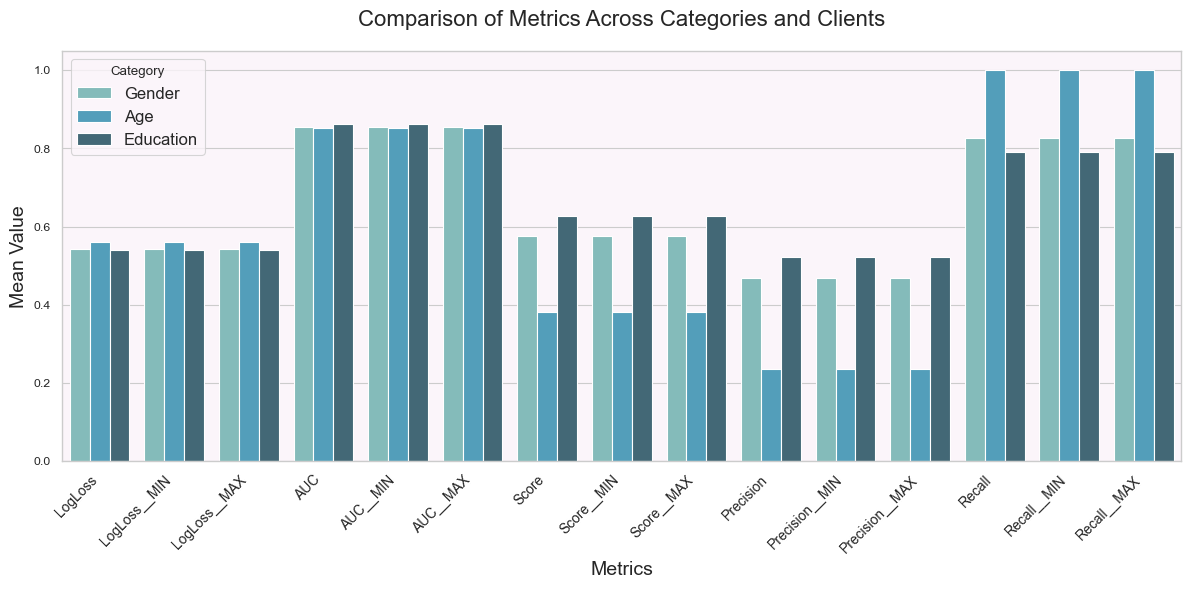

In [385]:
filtered_data = combined_melted[~combined_melted['Metric'].str.contains('Round')]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=filtered_data, 
    x='Metric', y='Value', hue='Category', 
    palette='GnBu_d', errorbar=None
)

plt.title('Comparison of Metrics Across Categories and Clients', fontsize=16, y=1.04)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Mean Value', fontsize=14)
plt.legend(title='Category', fontsize=12, loc="upper left")
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.tight_layout()
plt.show()


<br>
Here, Age shows the highest Recall, demonstrating superior sensitivity in identifying positive outcomes compared to Gender and Education.<br>
Regarding Precision, Education slightly outperforms other categories, though it remains consistently low, indicating a trade-off for high Recall.<br>
Gender and Age categories achieve comparable, stable AUC scores, reflecting reliable overall model discrimination across these categories.<br>
All categories maintain relatively low LogLoss, indicating good prediction confidence.<br>
The plot effectively highlights variability across metrics and categories, making it easier to identify strengths (e.g., Recall for Age) and weaknesses (e.g., Precision for Gender and Age).

<br><br>
<div style="border-top: 3px dotted #D1DFDF"></div>
<br>

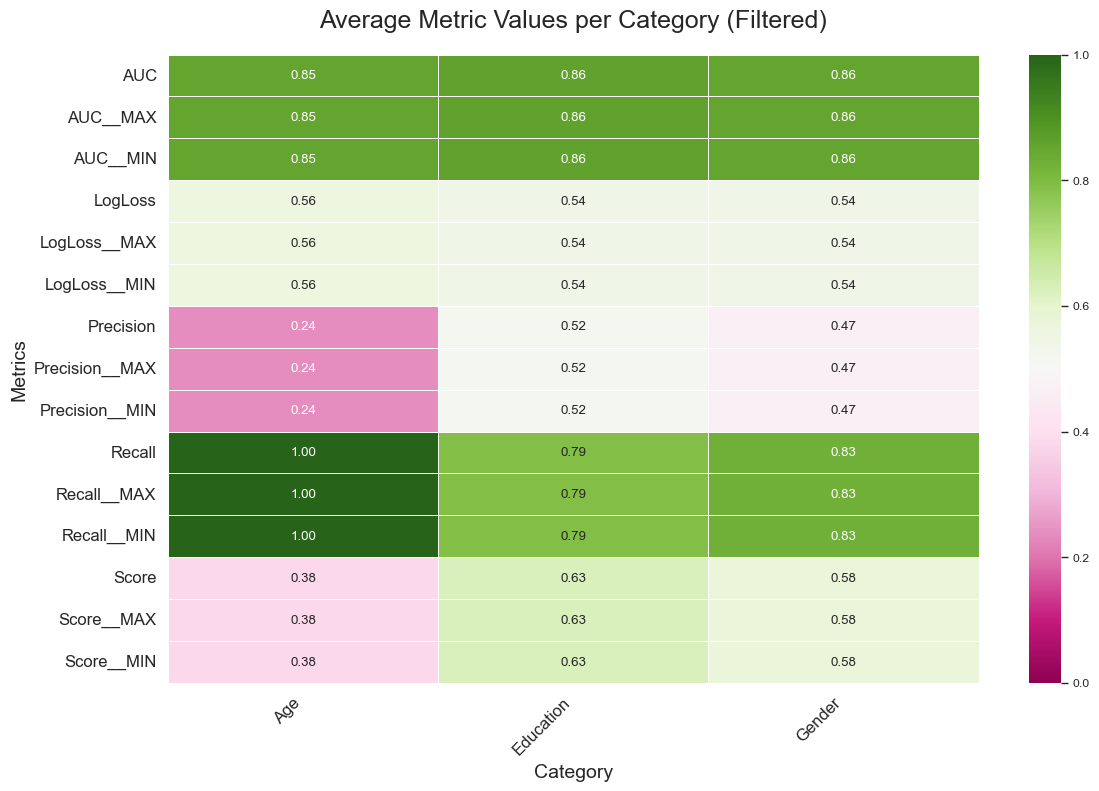

In [404]:
best_values_avg = combined_melted.groupby(['Metric', 'Category'])['Value'].mean().reset_index()
best_table_avg = best_values_avg.pivot(index='Metric', columns='Category', values='Value')

filtered_best_table_avg = best_table_avg[~best_table_avg.index.str.contains('Round')]

plt.figure(figsize=(12, 8))
sns.heatmap(
    filtered_best_table_avg, 
    annot=True, 
    fmt=".2f", 
    cmap="PiYG", 
    cbar=True,
    linewidths=0.5,
    vmin=0,
    vmax=1
)
plt.title('Average Metric Values per Category (Filtered)', fontsize=18, y=1.03)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


The heatmap provides an insightful overview of the average metric values across the categories of Age, Education, and Gender.
<br>
Starting with **AUC**, the Education and Gender categories achieve the highest average scores of **0.86**, slightly outperforming the Age category at **0.85**. This indicates that the XGBoost model trained with data skewed by education level and gender exhibit the most consistent classification ability across all thresholds.
<br>
**LogLoss**, which measures the confidence of predictions, remains consistent across all categories with an average value of **0.54**. This might indicate that the confidence of the model's predictions is not significantly influenced by the type of data skewing applied, whether it is Age, Education, or Gender.
<br>
When examining **Precision**, the Age-skewed data leads with a score of **0.52**, followed by Education at **0.47** and Gender at **0.24**. This shows that the XGBoost model, trained on age-skewed data, is better at minimizing false positives compared to the runs where it was trained on education- or gender-skewed data.
<br>
On the other hand, **Recall** shows a different trend, with Gender achieving a perfect score of **1.00**, while Education and Age follow with scores of **0.83** and **0.79**, respectively. This highlights that the model trained on Gender-skewed data prioritizes capturing all positive cases, which also indicate a high likelihood of potential overfitting.

Finally, in terms of the overall **F1-Score**, Education-skewed data leads with the highest value of **0.63**, followed by Age at **0.58** and Gender at **0.38**. This suggests that the model (in the Education-Run) is able to strike a better balance between precision and recall, as reflected in a higher overall score.

<br>
<div style="border-top: 3px dotted #D1DFDF"></div>

## Conclusion of all three plots
The heatmap provides an aggregate summary of average metric values per category, offering a bird’s-eye view of performance. The bar plots add depth by showing the client-level breakdown and overall category-level comparison.
<br>
#### **Age**:
Consistently excels in Recall, suggesting the Age-skewed data aligns (too) well with the model's sensitivity.

#### **Education**:
Slightly better Precision, albeit at the cost of Recall.

#### **Gender**: 
Shows balanced performance, with relatively stable AUC and moderate Recall.
<br><br>

High Recall comes at the cost of Precision, especially for Age. This aligns with often cited trade-offs in imbalanced datasets or skewed distributions.
<br>LogLoss remains consistent across categories, reflecting robust model calibration.<br><br>
<hr>

# 8. Problems & Challenges

During the implementation of the Federated XGBoost model, several challenges came up, especially with **non-IID data distribution** and the increasing number of clients. In the 200-client setup, for example, it became clear that the model struggled to train well on the data. To deal with this, it was necessary to introduce thresholds to make the training process more stable, which added slightly more complexity to the setup.<br><br>

Another problem was the **initial setup of the tools**, especially `wandb.ai` and the `Flower framework`.<br>
`wandb.ai` is quite the powerful tracking tool, but its UI wasn’t intuitive at first. It also took a lot of debugging to figure out where the data was logged, what metrics were missing, and how to fix it. Similarly, the Flower framework required some practice and time to learn through its documentation.<br>Once the tools were properly set up, things got smoother, but getting there wasn’t a piece of cake.<br><br>

The **interpretation of results** was another challenging part. The raw data from `wandb.ai` needed some cleaning and preprocessing before it could be visualized. This was especially true for the three categories (Gender, Age, and Education), where it was crucial to carefully organize and normalize the data. Choosing the right way to visualize the results was also difficult. While heatmaps gave an overview, bar charts provided more detailed insights, but they were harder to read.<br><br>

One big issue was the **trade-off between precision and recall**. For example, in the setup with 200 clients, the model showed very high recall, but precision and other metrics were very low. This made it clear that the model wasn’t performing well, quite the contrary. Finding the right balance between these metrics would need better optimization techniques.<br><br>

Lastly, **time constraints** were a big limitation. There wasn’t enough time to refine the model further or make it more robust and sophisticated. Adding features like privacy-preserving techniques (e.g., encryption or differential privacy) and improving the model’s resistance to client drift would have required more time and research on how to implement it on a Federated XGBoost model. While the project met its main goals, the results are not as strong as they could have been with more time.<br><br>

In conclusion, while the project highlighted important issues in federated learning, especially with non-IID data and scaling to many clients, it also showed that interpreting and presenting results in a clear way is a challenge. Despite these issues, the work provides a strong foundation for future improvements.<br>

<br><br>
<div style="border-top: 3px dotted #D1DFDF"></div>
<br>

## Addition to Problems & Challenges: Use of Thresholds

#### **Why was a Threshold introduced?**
Initial results showed that `y_pred` consisted almost entirely of `0.0` values:<br>
 Nearly 100% of predictions were classified as negative (`0`).<br>
This caused Precision, Recall, and F1-Score to be `0`, as there were no true positives.
<br>By lowering the threshold to approx. `~0.3`, more samples were classified as positive (`1`), even if their predicted probabilities were slightly lower.
This adjustment allowed the calculation of Recall and F1-Score, as true positives could now be identified.

#### What is a Threshold and why/when should it be used?
The threshold is a cutoff value that determines whether a predicted probability from a model (e.g., XGBoost) is classified as positive (`1`) or negative (`0`). Instead of directly predicting `0` or `1`, the model outputs a probability (e.g., `0.3` or `0.7`), and the threshold defines at what probability a sample is considered "positive."<br>
The default threshold of `0.5` works well for balanced datasets. However, for imbalanced datasets (like in this case), lowering the threshold helps the model identify more positive cases, improving **Recall**.

#### Observations and Reasons for introducing a Threshold:

1. **Imbalanced Dataset:**
The dataset has significantly more negative (`0`) than positive (`1`) labels. Without balancing techniques or adjustments, the model is heavily biased toward predicting negatives.

2. **Effect of Threshold Adjustment:**
Lowering the threshold from `0.5` to `0.3` allowed the model to recognize more positive cases, improving Recall and F1-Score.
This demonstrates that the model has the capacity to identify positives, but the default threshold of 0.5 was unsuitable for this dataset.

<hr>
<br>

# 9. Findings

## Federated XGBoost and Non-IID Data

During the research of this assignment, the paper *"Federated XGBoost on Sample-Wise Non-IID Data."* was a helpful addition in implementing the model. 
The assignment’s observation that non-SMOTE setups often outperform SMOTE (e.g., higher AUC and F1-Score) aligns with the paper’s key finding that model performance is heavily influenced by the distribution and quality of data. Both works highlight that non-IID data introduces significant challenges for federated XGBoost models, emphasizing the importance of more sophisticated strategies to improve performance. Additionally, the project’s findings on the trade-offs introduced by SMOTE, such as improved Recall but reduced AUC, underlines the paper’s broader point about the sensitivity of federated models to imbalanced or synthetic data inputs.
<br><br>
The assignment shares key objectives with the paper, especially in applying federated XGBoost to non-IID data and evaluating its performance. However, the assignment task adds value by focusing on practical aspects such as **SMOTE, threshold optimization, and real-world data skewing experiments**. These differences make the project a complementary contribution to the insights presented in the paper, offering a more applied perspective on federated XGBoost challenges.


# 10. Further Measures

## Actions to tackle Client Drift

Client drift occurs when local models trained on non-IID data diverge significantly from the global model, reducing the effectiveness of aggregation and model performance. In this assignment, client drift posed challenges, particularly when dealing with highly skewed data distributions across 200 clients. To address client drift, the following actions can be considered:

1. **Adaptive Federated Optimization**:  
   While traditional methods like FedProx are not directly applicable to XGBoost, a similar concept can be adapted by penalizing updates from clients with higher divergence (e.g., based on their contribution to the global gradient statistics or split gain). This ensures smoother aggregation of tree structures.

2. **Weighted Aggregation**:  
   In XGBoost, weights can be assigned to client updates (gradients or histograms) based on the size, quality, or representativeness of the client’s dataset. This approach can mitigate the effect of highly skewed or biased client distributions.

3. **Data Regularization at Local Levels**:  
   Adding minor random perturbations or noise to local gradients can strenghten models and make them less sensitive to extrem outliers caused by skewed data.<

4. **Client Sampling**:  
   Instead of aggregating updates from all clients, one should sample clients whose data distributions align more closely with the global dataset. This can stabilize the tree-building process.

5. **Histogram Equalization Across Clients**:
Histograms are used for split finding in XGBoost. Ensuring that histograms from different clients are balanced, by adjusting bins to align distributions, can reduce the variance caused by non-IID data.


<br>
<div style="border-top: 3px dotted #D1DFDF"></div>
<br>

## Privacy-preserving Measures

Protecting client data privacy is a critical aspect of federated learning, and implementing privacy-preserving techniques ensures compliance with regulations and builds trust in the system. Based on the further down below referenced papers, the following measures could be applied:

1. **Differential Privacy (DP)**:  
   Introduce noise to the client updates before sharing them with the server. Techniques like *Local Differential Privacy (LDP)* ensure that individual data points cannot be reconstructed from the updates, providing strong privacy guarantees. For example, in XGBoost, adding noise during gradient or Hessian computation can help achieve privacy-preservation.

2. **Secure Aggregation (SA)**:  
   Use cryptographic methods to ensure that the server only receives aggregated updates without accessing individual client contributions. Methods like *homomorphic encryption* or *secure multi-party computation (SMPC)* can be applied to aggregate gradients while keeping individual updates confidential.

3. **Gradient Sparsification**:  
   Transmit only the most significant gradients or updates from clients. This reduces the data exposure risk and the communication cost. Combined with noise addition, this method offers privacy preservation with minimal overhead.

4. **Federated XGBoost with SMM (Secure Matrix Multiplication)**:  
   As suggested in the referenced papers, implementing secure matrix multiplication in XGBoost can prevent the exposure of data-related parameters during model training. Data interactions remain private, even during complex computations.

5. **Model Masking**:  
   Masking the local models with random noise or obfuscation techniques before sending them to the server. Even if intercepted, the updates do not reveal sensitive information.

6. **Federated Adversarial Training**:  
   Training the global model to withstand potential privacy attacks by introducing adversarial noise into the training process. Doing this increases the robustness of the system and protects against model inversion attacks.

7. **Auditing and Transparency**:  
   Implement transparency measures such as differential privacy budgets or auditing logs to track the level of privacy achieved.<br><br>
   <hr>

# Sources:



[1] K. Bonawitz et al., "Towards Federated Learning at Scale: System Design," in *Proceedings of Machine Learning and Systems*, vol. 1, pp. 374-388, 2019. Available: https://arxiv.org/pdf/2106.10662

[2] X. Liu, L. Lyu, Q. Wang, H. Yu, and Q. Yang, "FedXGBoost: Privacy-Preserving XGBoost for Federated Learning," in *Proceedings of the 37th AAAI Conference on Artificial Intelligence*, 2023. Available: https://arxiv.org/pdf/2304.07537v3

[3] H. B. McMahan et al., "Advances and Open Problems in Federated Learning," in *Proceedings of the 22nd International Workshop on Artificial Intelligence and Statistics (AISTATS)*, 2019. Available: https://federated-learning.org/fl-aaai-2022/Papers/FL-AAAI-22_paper_25.pdf